### DS 340H: Final Project
By: Tayae Rogers \
Date: 11/15/2024

In [1]:
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform, Transformer
# from geopy.geocoders import Nominatim
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import requests
import seaborn as sns

In [2]:
os.chdir("/Users/tayaerogers/Desktop/DS340H/FinalProject")

### Reading in data

In [109]:
# Blue Bike rides
june22 = pd.read_csv('202206-bluebikes-tripdata.csv')
july22 = pd.read_csv('202207-bluebikes-tripdata.csv')
aug22 = pd.read_csv('202208-bluebikes-tripdata.csv')

bike_rides = pd.concat([june22, july22, aug22])

In [72]:
# Blue Bike stations
bike_stations = pd.read_csv('current_bluebikes_stations.csv', header=1)

In [5]:
# MBTA rides
T_rides_Q2 = pd.read_csv('TravelTimes_2022/2022-Q2_HRTravelTimes.csv')
T_rides_Q3 = pd.read_csv('TravelTimes_2022/2022-Q3_HRTravelTimes.csv')

T_rides = pd.concat([T_rides_Q2, T_rides_Q3])

In [6]:
# MBTA stations
T_stations = gpd.read_file('mbta_rapid_transit/MBTA_NODE.shp')

### Data cleaning

##### Blue Bike stations and rides

In [111]:
bike_rides['start station latitude'].unique()

array([42.40935396, 42.36895181, 42.366426  , 42.34740621, 42.352409  ,
       42.36507   , 42.33639915, 42.36860524, 42.34992828, 42.34655124,
       42.341598  , 42.34369056, 42.3722168 , 42.34157472, 42.35317809,
       42.3595732 , 42.366277  , 42.373268  , 42.36224179, 42.3598254 ,
       42.3733288 , 42.36135838, 42.38762811, 42.348706  , 42.35766248,
       42.33741748, 42.36550729, 42.37250865, 42.340814  , 42.3501061 ,
       42.36473899, 42.341814  , 42.36079297, 42.34908155, 42.35560121,
       42.36599433, 42.39189812, 42.34958942, 42.34012243, 42.3664204 ,
       42.352175  , 42.36356016, 42.36526032, 42.39223284, 42.36884408,
       42.37426714, 42.37412455, 42.36544486, 42.36371276, 42.31786021,
       42.33554308, 42.335741  , 42.38445226, 42.35533502, 42.36955298,
       42.35114198, 42.36242784, 42.34827839, 42.36346469, 42.36041775,
       42.33624445, 42.365673  , 42.387995  , 42.3502102 , 42.3625    ,
       42.37875351, 42.348717  , 42.35169202, 42.35668335, 42.34

In [75]:
# Make a df of stations in Cambridge
bike_stations_cambridge = bike_stations[bike_stations['Municipality'] == 'Cambridge'].reset_index(drop=True)
bike_stations_cambridge = bike_stations_cambridge.rename(columns={'Lat':'latitude', 'Long':'longitude'})

# Make a list of stations in Cambridge
bike_stations_cambridge_ls = bike_stations_cambridge['NAME'].to_list()

# Subset to bike rides that started and ended in Cambridge
bike_rides = bike_rides[(bike_rides['start station name'].isin(bike_stations_cambridge_ls)) & (bike_rides['end station name'].isin(bike_stations_cambridge_ls))].reset_index(drop=True)

# Match column name for travel_time_sec and create travel_time_min
bike_rides = bike_rides.rename(columns={'tripduration':'travel_time_sec'})
bike_rides['travel_time_min'] = bike_rides['travel_time_sec']/60

# Save
bike_rides.to_csv("Bike_Rides_Cambridge.csv")

##### T rides/trains

In [8]:
# Subset to rides taken in summer 2022
T_rides['service_date'] = pd.to_datetime(T_rides['service_date'])
T_rides = T_rides[(T_rides['service_date'] >= '2022-06-01') & (T_rides['service_date'] < '2022-09-01')].reset_index()

# Goal: Subset to T paths that start and end in Cambridge
### Method 1: Manually get list of relevant stops
### Method 2: Maybe I don't need to formally do this if I know latitude and longitude and the time it takes to walk to these stops

In [9]:
# Revise service date, start time, and end time
# Based on data source notes
T_rides.loc[T_rides['start_time_sec'] >= 60*60*24, 'service_date'] += datetime.timedelta(days=1)
T_rides.loc[T_rides['start_time_sec'] >= 60*60*24, 'start_time_sec'] -= 60*60*24
T_rides.loc[T_rides['start_time_sec'] >= 60*60*24, 'end_time_sec'] -= 60*60*24

In [10]:
# Make sure editing time worked
print(T_rides['start_time_sec'].describe())
print(T_rides['start_time_sec'].max() < 60*60*24)

count    8.343180e+06
mean     5.098149e+04
std      2.063619e+04
min      0.000000e+00
25%      3.463200e+04
50%      5.177200e+04
75%      6.794600e+04
max      8.639900e+04
Name: start_time_sec, dtype: float64
True


In [11]:
# Create new columns for reference
T_rides['start_time_min'] = T_rides['start_time_sec']/60
T_rides['end_time_min'] = T_rides['end_time_sec']/60

T_rides['start_time_hour'] = T_rides['start_time_min']/60
T_rides['end_time_hour'] = T_rides['end_time_min']/60

# TO DO: Something with fixing the date and time alignment
# TO DO: Merge in T_station data so I have latitude and longitude in this one dataframe at some point?

In [20]:
T_rides.to_csv("Summer2022_HRTravelTimes.CSV")
T_rides

,index,service_date,from_stop_id,to_stop_id,route_id,direction_id,start_time_sec,end_time_sec,travel_time_sec,start_time_min,end_time_min,start_time_hour,end_time_hour
0,6945115,2022-06-01,70002,70001,Orange,0,21862,21977,115,364.366667,366.283333,6.072778,6.104722
1,6945116,2022-06-01,70002,70001,Orange,0,21514,21641,127,358.566667,360.683333,5.976111,6.011389
2,6945117,2022-06-01,70002,70001,Orange,0,23160,23286,126,386.000000,388.100000,6.433333,6.468333
3,6945118,2022-06-01,70002,70001,Orange,0,22639,22723,84,377.316667,378.716667,6.288611,6.311944
4,6945119,2022-06-02,70002,70001,Orange,0,3736,90256,120,62.266667,1504.266667,1.037778,25.071111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8343175,5219859,2022-08-31,70039,70838,Blue,0,30397,30437,40,506.616667,507.283333,8.443611,8.454722
8343176,5219860,2022-08-31,70039,70838,Blue,0,59637,59677,40,993.950000,994.616667,16.565833,16.576944
8343177,5219861,2022-08-31,70039,70838,Blue,0,60879,60913,34,1014.650000,1015.216667,16.910833,16.920278
8343178,5219862,2022-08-31,70039,70838,Blue,0,59777,59856,79,996.283333,997.600000,16.604722,16.626667


##### T stations

In [12]:
# Calculate longitude and latitude values for each coordinate geometry point
# Convert from NAD83 to regular coordinates
def convert_longLat(geo_df):
    inProj = Proj(init="epsg:26986", preserve_units=True)
    outProj = Proj(init='epsg:4326')

    long_conv, lat_conv = transform(inProj, outProj, geo_df.geometry.x, geo_df.geometry.y)

    geo_df['latitude'] = lat_conv
    geo_df['longitude'] = long_conv

    return geo_df

T_stations = convert_longLat(T_stations)
# Note: Gives me a "this function is deprecated" warning but it runs

/Users/tayaerogers/miniconda3/envs/proj2/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/tayaerogers/miniconda3/envs/proj2/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_57593/285248274.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/sta

### Finding closest T stop to each bike station

In [13]:
# Subsetting to T stations in Cambridge
# Note: Figure out how to do this more automatically? One option: subset to stations in Cambridge using geopy.geocoders and Nominatim
cambridge_station_ls = ['Alewife', 'Central', 'Harvard', 'Kendall/MIT', 'Porter'] 
T_stations_cambridge = T_stations[T_stations['STATION'].isin(cambridge_station_ls)]

In [14]:
T_stations_cambridge.to_csv("TStations_Cambridge.csv")
T_stations_cambridge

,STATION,LINE,TERMINUS,ROUTE,geometry,latitude,longitude
56,Harvard,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (231387.274 902684.016),42.374029,-71.118906
57,Kendall/MIT,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (234087.917 901406.551),42.362415,-71.086191
87,Alewife,RED,Y,A - Ashmont B - Braintree C - Alewife,POINT (229468.582 905129.626),42.396121,-71.142077
88,Porter,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (231363.042 904271.357),42.388320,-71.119114
89,Central,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (232633.774 901735.613),42.365440,-71.103825


In [76]:
bike_stations_cambridge.to_csv("BikeStations_Cambridge.csv")
bike_stations_cambridge

,Number,NAME,latitude,longitude,Seasonal Status,Municipality,Total Docks,Station ID (to match to historic system data)
0,M32002,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,Year Round,Cambridge,19.0,91
1,M32003,One Broadway / Kendall Sq at Main St / 3rd St,42.362242,-71.083111,Year Round,Cambridge,23.0,72
2,M32004,Kendall T,42.362428,-71.084955,Year Round,Cambridge,23.0,189
3,M32005,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,Year Round,Cambridge,35.0,80
4,M32006,MIT at Mass Ave / Amherst St,42.358100,-71.093198,Year Round,Cambridge,27.0,67
...,...,...,...,...,...,...,...,...
84,M32089,Moore Youth Center,42.363539,-71.111698,Year Round,Cambridge,15.0,No ID pre-March 2023
85,M32090,O'Brien Highway at First Street,42.370982,-71.076638,Year Round,Cambridge,19.0,No ID pre-March 2023
86,M32091,325 Binney St.,42.367220,-71.089030,Year Round,Cambridge,19.0,No ID pre-March 2023
87,M32001,Lechmere Station at Cambridge St / First St,42.370677,-71.076529,Year Round - Currently Stored,Cambridge,19.0,NaN


### Google Maps API

In [22]:
# Goal structure: {(bike_station_lat, bike_station_long): {(MBTA_station_lat1, MBTA_station_long1): walking_time_from_google_maps_api1, (MBTA_station_lat2, MBTA_station_long2): walking_time_from_google_maps_api2, etc}}
full_dist_dict={}
key='' # INSERT OWN KEY

### QUESTION: Does something about "string" manipulate the length of the strings?

# Iterates through bike station
for row_bike,index_bike in bike_stations_cambridge.iterrows():
   
    bike_station_coords=str(index_bike['latitude']) + ',' + str(index_bike['longitude'])
    bike_station_dict={}

    for row_T, index_T in T_stations_cambridge.iterrows():
        destination=str(index_T['latitude']) + ',' + str(index_T['longitude'])
        print(destination)
        response = requests.get(f"https://maps.googleapis.com/maps/api/directions/json?destination={destination}&mode=walking&origin={bike_station_coords}&key={key}")
        walking_time = response.json()['routes'][0]['legs'][0]['duration']['value']
        bike_station_dict[(index_T['latitude'], index_T['longitude'])] = walking_time
        
    full_dist_dict[(index_bike['latitude'], index_bike['longitude'])] = bike_station_dict
    #print(response)

#print(response.json()['routes'][0]['legs'][0]['duration']['value']) # number of seconds it takes to walk from point a to point b)

42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396121027916756,-71.1420773119539
42.3883204798639,-71.11911421896355
42.36543993910913,-71.10382518006278
42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396121027916756,-71.1420773119539
42.3883204798639,-71.11911421896355
42.36543993910913,-71.10382518006278
42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396121027916756,-71.1420773119539
42.3883204798639,-71.11911421896355
42.36543993910913,-71.10382518006278
42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396121027916756,-71.1420773119539
42.3883204798639,-71.11911421896355
42.36543993910913,-71.10382518006278
42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396121027916756,-71.1420773119539
42.3883204798639,-71.11911421896355
42.36543993910913,-71.10382518006278
42.37402923084183,-71.11890607285167
42.36241534494076,-71.08619149362897
42.396

In [73]:
# Gut checks
print(len(full_dist_dict.keys()))
print(len([full_dist_dict[i][key] for key in full_dist_dict[i].keys() for i in full_dist_dict.keys()]))
all_walking_time = [full_dist_dict[i][key] for key in full_dist_dict[i].keys() for i in full_dist_dict.keys()]
print(full_dist_dict)

89
445


In [25]:
# Write to CSV
full_dist_df = pd.DataFrame(full_dist_dict)
full_dist_df.to_csv("API_distance.csv")

#### Visualization: All Bike-Station-to-T Station Walk Times

[Text(0.5, 0, 'All Bike-Station-to-T-Station Walks'),
 Text(0, 0.5, 'Walking Time (Seconds)')]

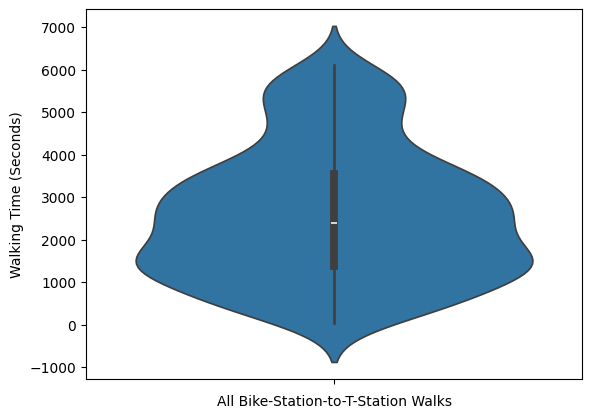

In [78]:
ax = sns.violinplot(data=all_walking_time)
ax.set(xlabel='All Bike-Station-to-T-Station Walks', ylabel='Walking Time (Seconds)')

In [170]:
# Goal dict:
# Dict of dicts
# {(bike_station_lat, bike_station_long): {(MBTA_station_lat1, MBTA_station_long1): walking_time_from_google_maps_api1, (MBTA_station_lat2, MBTA_station_long2): walking_time_from_google_maps_api2, etc}}

# Steps
### Create function that takes in a bike_station_name, bike_station_lat, and bike_station_long
### Finds walking time to each T station (calling Google Maps API)
### Finds minimum walking time
### Outputs a tuple (bike_station_name1, bike_station_lat1, bike_station_long1, walking_time_from_google_maps_api1) 

# Next
# Merge this df onto bike ride station

# Next
# Q: Repeat for end station? -- Do I need to recalculate walking time or can I assume it's the same both ways?

### Calculating alternative straight walking time for each set of bike stations

In [ ]:
# Goal structure: {(bike_station_lat, bike_station_long): {(MBTA_station_lat1, MBTA_station_long1): walking_time_from_google_maps_api1, (MBTA_station_lat2, MBTA_station_long2): walking_time_from_google_maps_api2, etc}}
full_bike_station_dist_dict={}
key='' # INSERT OWN KEY

# Iterates through bike station
for row_bike,index_bike in bike_stations_cambridge.iterrows():
   
    bike_station_coords=str(index_bike['latitude']) + ',' + str(index_bike['longitude'])
    bike_station_dict2={}

    for row_bike2, index_bike2 in bike_stations_cambridge.iterrows():
        destination=str(index_bike2['latitude']) + ',' + str(index_bike2['longitude'])
        print(destination)
        response = requests.get(f"https://maps.googleapis.com/maps/api/directions/json?destination={destination}&mode=walking&origin={bike_station_coords}&key={key}")
        walking_time = response.json()['routes'][0]['legs'][0]['duration']['value']
        bike_station_dict2[(index_bike2['latitude'], index_bike2['longitude'])] = walking_time
        
    full_bike_station_dist_dict[(index_bike['latitude'], index_bike['longitude'])] = bike_station_dict2

42.366277,-71.09169


IndexError: list index out of range

### Read in data (to start work 11/15/2024)

In [168]:
T_rides = pd.read_csv("Summer2022_HRTravelTimes.CSV")
bike_rides = pd.read_csv("Bike_Rides_Cambridge.csv")

full_dist_df = pd.read_csv("API_distance.csv")
#full_dist = full_dist_df.to_dict()

full_bike_station_dist_df = pd.read_csv("API_distance_between_bike_stations.csv")
#full_bike_station_dist = full_bike_station_dist_df.to_dict('series')

In [169]:
full_bike_station_dist_df

,Unnamed: 0,Unnamed: 1,42.3663,42.3622,42.3624,42.3621,42.3581,42.373,42.3635,42.3651,...,42.3636.1,42.372.1,42.3743.1,42.3908,42.3641,42.3635.1,42.371,42.3672,42.3707,42.3699.1
0,NaN,NaN,-71.0917,-71.0831,-71.085,-71.0912,-71.0932,-71.0944,-71.1006,-71.1031,...,-71.1004,-71.0759,-71.1197,-71.1439,-71.0874,-71.1117,-71.0766,-71.089,-71.0765,-71.0735
1,42.3663,-71.0917,0.0000,760.0000,690.000,489.0000,990.0000,777.0000,866.0000,1063.0000,...,833.0000,1626.0000,2291.0000,4627.0000,412.0000,1772.0000,1453.0000,283.000,1420.0000,1681.0000
2,42.3622,-71.0831,752.0000,0.0000,199.000,681.0000,1136.0000,1529.0000,1314.0000,1511.0000,...,1281.0000,1381.0000,2962.0000,5298.0000,342.0000,2220.0000,1208.0000,795.000,1175.0000,1302.0000
3,42.3624,-71.0850,685.0000,199.0000,0.000,482.0000,937.0000,1462.0000,1115.0000,1312.0000,...,1082.0000,1407.0000,2877.0000,5211.0000,328.0000,2021.0000,1234.0000,781.000,1201.0000,1462.0000
4,42.3621,-71.0912,487.0000,682.0000,483.000,0.0000,549.0000,1264.0000,804.0000,1001.0000,...,771.0000,1890.0000,2566.0000,4997.0000,465.0000,1710.0000,1717.0000,610.000,1684.0000,1945.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,42.3635,-71.1117,1769.0000,2220.0000,2021.000,1709.0000,1670.0000,1741.0000,941.0000,719.0000,...,936.0000,3179.0000,1468.0000,3899.0000,1991.0000,0.0000,3006.0000,2040.000,2973.0000,3234.0000
86,42.3710,-71.0766,1432.0000,1193.0000,1228.000,1710.0000,2132.0000,1271.0000,2296.0000,2382.0000,...,2263.0000,211.0000,3141.0000,5460.0000,1310.0000,2996.0000,0.0000,1269.000,77.0000,266.0000
87,42.3672,-71.0890,278.0000,798.0000,784.000,611.0000,1136.0000,826.0000,1132.0000,1329.0000,...,1099.0000,1452.0000,2512.0000,4831.0000,450.0000,2038.0000,1279.0000,0.000,1246.0000,1507.0000
88,42.3707,-71.0765,1405.0000,1166.0000,1201.000,1683.0000,2105.0000,1244.0000,2269.0000,2355.0000,...,2236.0000,206.0000,3114.0000,5433.0000,1283.0000,2969.0000,83.0000,1242.000,0.0000,261.0000


In [170]:
bike_rides

,Unnamed: 0,travel_time_sec,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code,travel_time_min
0,0,699,2022-06-01 00:00:09.7250,2022-06-01 00:11:49.4790,515,955 Mass Ave,42.368952,-71.109988,115,Porter Square Station,42.387995,-71.119084,4454,Subscriber,02144,11.650000
1,1,439,2022-06-01 00:00:12.2310,2022-06-01 00:07:32.1780,76,Central Sq Post Office / Cambridge City Hall a...,42.366426,-71.105495,544,Old Morse Park at Putnam Ave,42.357662,-71.108413,7397,Subscriber,02138,7.316667
2,2,674,2022-06-01 00:00:58.1190,2022-06-01 00:12:12.9300,386,Sennott Park Broadway at Norfolk Street,42.368605,-71.099302,386,Sennott Park Broadway at Norfolk Street,42.368605,-71.099302,6235,Subscriber,02139,11.233333
3,3,233,2022-06-01 00:01:06.8320,2022-06-01 00:05:00.3840,386,Sennott Park Broadway at Norfolk Street,42.368605,-71.099302,116,359 Broadway - Broadway at Fayette Street,42.370803,-71.104412,4760,Subscriber,02139,3.883333
4,4,635,2022-06-01 00:01:19.4580,2022-06-01 00:11:55.4460,76,Central Sq Post Office / Cambridge City Hall a...,42.366426,-71.105495,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,7406,Subscriber,02141,10.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256678,256678,328,2022-08-31 23:59:10.9450,2022-09-01 00:04:39.0900,179,MIT Vassar St,42.355601,-71.103945,177,University Park,42.362648,-71.100061,4443,Subscriber,02139,5.466667
256679,256679,1961,2022-08-31 23:59:14.0120,2022-09-01 00:31:55.7390,143,EF - North Point Park,42.369885,-71.069957,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,2948,Subscriber,NaN,32.683333
256680,256680,648,2022-08-31 23:59:17.2390,2022-09-01 00:10:05.9220,73,Harvard Square at Brattle St / Eliot St,42.373329,-71.120986,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,5570,Subscriber,NaN,10.800000
256681,256681,591,2022-08-31 23:59:44.9190,2022-09-01 00:09:36.0490,67,MIT at Mass Ave / Amherst St,42.358100,-71.093198,84,CambridgeSide Galleria - CambridgeSide PL at L...,42.367074,-71.076793,6399,Subscriber,02139,9.850000


### Finding length of non-bike trips for each bike ride

In [ ]:
####################################################################################################
### Once I establish the same # of digits in the coordinates in the bike ride dataset + full_df, ###
################ I can now match walk time from start to end station by coordinates ################
####################################################################################################

In [156]:
## Experimentation (all digits)
# bike_rides['start_coords'] = bike_rides[['start station latitude', 'start station longitude']].apply(tuple, axis=1)
# bike_rides['end_coords'] = bike_rides[['end station latitude', 'end station longitude']].apply(tuple, axis=1)

# print(len(bike_rides['start_coords'].unique()))
# print(len(bike_rides['end_coords'].unique()))

## Experimentation (4 digits)
bike_rides['start station latitude'] = bike_rides['start station latitude'].round(4)
bike_rides['start station longitude'] = bike_rides['start station longitude'].round(4)
bike_rides['end station latitude'] = bike_rides['end station latitude'].round(4)
bike_rides['end station longitude'] = bike_rides['end station longitude'].round(4)

bike_rides['start_coords'] = bike_rides[['start station latitude', 'start station longitude']].apply(tuple, axis=1)
bike_rides['end_coords'] = bike_rides[['end station latitude', 'end station longitude']].apply(tuple, axis=1)

print(len(bike_rides['start_coords'].unique()))
print(len(bike_rides['end_coords'].unique()))

## Experimentation (3 digits)
# bike_rides['start station latitude3'] = bike_rides['start station latitude'].round(3)
# bike_rides['start station longitude3'] = bike_rides['start station longitude'].round(3)
# bike_rides['end station latitude3'] = bike_rides['end station latitude'].round(3)
# bike_rides['end station longitude3'] = bike_rides['end station longitude'].round(3)

# bike_rides['start_coords3'] = bike_rides[['start station latitude3', 'start station longitude3']].apply(tuple, axis=1)
# bike_rides['end_coords3'] = bike_rides[['end station latitude3', 'end station longitude3']].apply(tuple, axis=1)

# print(len(bike_rides['start_coords3'].unique()))
# print(len(bike_rides['end_coords3'].unique()))

# print(len(bike_rides['start station latitude3'].unique()))
# print(len(bike_rides['start station longitude3'].unique()))
# print(len(bike_rides['end station latitude3'].unique()))
# print(len(bike_rides['end station longitude3'].unique()))

75
75


In [148]:
########################################
### Converting the df back to a dict ###
########################################

full_bike_station_dist_df = pd.read_csv("API_distance_between_bike_stations.csv")

full_bike_station_dist_df['Unnamed: 0'] = full_bike_station_dist_df['Unnamed: 0'].round(4)
full_bike_station_dist_df['Unnamed: 1'] = full_bike_station_dist_df['Unnamed: 1'].round(4)

full_bike_station_dist_df['tuple_coords'] = full_bike_station_dist_df[['Unnamed: 0', 'Unnamed: 1']].apply(tuple, axis=1)
full_bike_station_dist_df.drop(['Unnamed: 0', 'Unnamed: 1'], axis=1, inplace=True)
#full_bike_station_dist_df.set_index('tuple_index', inplace=True)

new_columns = [(float(".".join(col.split(".",2)[:2])), full_bike_station_dist_df[col].iloc[0]) for col in full_bike_station_dist_df.columns if col != 'tuple_coords']
new_columns.append('tuple_coords') 
full_bike_station_dist_df.columns = new_columns

full_bike_station_dist_df = full_bike_station_dist_df.iloc[1:]
full_bike_station_dist_df

full_df = {}
coord_cols = full_bike_station_dist_df.columns[:-1]
coord_cols = [(round(coords[0],4), round(coords[1],4)) for coords in coord_cols]
# coord_cols = [('{:.4f}'.format(round(coords[0],4)), '{:.4f}'.format(round(coords[1],4))) for coords in coord_cols]
for row, index in full_bike_station_dist_df.iterrows():
    count=0
    if index['tuple_coords'] not in full_df:
        full_df[index['tuple_coords']]={}
        while count < len(coord_cols):
            full_df[index['tuple_coords']][coord_cols[count]] = index[count]
            count += 1

full_bike_station_dist_dict = full_df

/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_3676/2865559328.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  full_df[index['tuple_coords']][coord_cols[count]] = index[count]


In [158]:
# Iterating over all bike rides
count=0
missing_start=set()
missing_end=set()
for row_bike,index_bike in bike_rides.iterrows():
   # Calculate straight walk time and put it in a new column
   # print(index_bike['end_coords'])
   # print(full_bike_station_dist_dict[index_bike['start_coords']].keys()) # [index_bike['end_coords']]
   try:
      full_bike_station_dist_dict[index_bike['start_coords']][index_bike['end_coords']]
   except KeyError:
      print(f"Key {[index_bike['start_coords'], index_bike['end_coords']]} not found")
      missing_start.add(index_bike['start_coords'])
      missing_end.add(index_bike['end_coords'])
      #print([index_bike['start_coords'], index_bike['end_coords']])
      count += 1

print(count)
print(len(missing_start))
print(missing_start)
print(len(missing_end))
print(missing_end)

   # bike_rides['straight_walk'] = full_bike_station_dist_dict[index_bike['start_coords']][index_bike['end_coords']]

   # print([key[1] for key in full_bike_station_dist_dict.items()])

Key [(42.3635, -71.1006), (42.3692, -71.1171)] not found
Key [(42.3692, -71.1171), (42.3666, -71.1142)] not found
Key [(42.3692, -71.1171), (42.3779, -71.1169)] not found
Key [(42.3779, -71.1169), (42.3692, -71.1171)] not found
Key [(42.373, -71.0944), (42.3692, -71.1171)] not found
Key [(42.3692, -71.1171), (42.3733, -71.1186)] not found
Key [(42.3692, -71.1171), (42.3692, -71.1171)] not found
Key [(42.3692, -71.1171), (42.3733, -71.1186)] not found
Key [(42.3596, -71.1013), (42.3692, -71.1171)] not found
Key [(42.3956, -71.1426), (42.3692, -71.1171)] not found
Key [(42.3692, -71.1171), (42.3596, -71.1013)] not found
Key [(42.3666, -71.1142), (42.3692, -71.1171)] not found
Key [(42.3692, -71.1171), (42.3666, -71.1142)] not found
Key [(42.3692, -71.1171), (42.3779, -71.1169)] not found
Key [(42.3722, -71.1219), (42.3692, -71.1171)] not found
Key [(42.3692, -71.1171), (42.3895, -71.139)] not found
Key [(42.3692, -71.1171), (42.379, -71.1199)] not found
Key [(42.369, -71.11), (42.3692, -

In [ ]:
# Iterating over all bike rides
for row_bike,index_bike in bike_rides.iterrows():
    # Calculate straight walk time and put it in a new column
    start_station_lat = str(round(index_bike['start station latitude'],5))
    start_station_long = str(round(index_bike['start station longitude'],5))
    end_station_lat = str(round(index_bike['end station latitude'],5))
    end_station_long = str(round(index_bike['end station longitude'],5))

    print([key[1] for key in full_bike_station_dist_dict.items()])

    # print([(key[0], key[1]) for key in full_bike_station_dist_dict.items() if 'start_station_lat' in key[0]])


    # print(index_bike)
    # bike_rides_sub = {(key[0][0], key[0][1]) for key in full_bike_station_dist_dict.items() if (str(round(key[0][0],5))).startswith(str(start_station_lat))} #  and (str(key[1])).startswith(str(start_station_long))
    # print(bike_rides_sub)


    # bike_rides['straight_walk'] = full_bike_station_dist_dict[start_station_coords][end_station_coords]

#### ISSUE: For some reason, this way is giving me longitude and latitude values with many more digits than what appears in the df and also than the longitude and latitudes values in the dict that I'm trying to reference

    # # Find nearest T station to starting bike station and walk time to the station
    # bike_rides['start_walk_station_coords'] = min(full_dist_dict['start_station_coords'], key=full_dist_dict['start_station_coords'].get)
    # bike_rides['start_walk_time'] = min(full_dist_dict['start_station_coords'].values())

    # # Find nearest T station to end bike station and walk time to the station
    # bike_rides['end_walk_station_coords'] = min(full_dist_dict['end_station_coords'], key=full_dist_dict['end_station_coords'].get)
    # bike_rides['end_walk_time'] = min(full_dist_dict['start_station_coords'].values())

    # Find relevant T

##### NEED IDs OF T STATIONS SO CAN MATCH WITH T STATION DF

In [ ]:
# Find nearest T station to starting bike station
for bike_ride in bike_rides:
    start_station_coords=str(bike_ride['latitude']) + ',' + str(bike_ride['longitude']) # check exact formatting
    end_station_coords=str(bike_ride['latitude']) + ',' + str(bike_ride['longitude']) # check exact formatting
    bike_rides['straight_walk'] = full_bike_station_dist_df['start_station_coords']['end_station_coords']

### Other work today

In [ ]:
bike_rides

In [27]:
full_dist_df

,,42.366277,42.362242,42.362428,42.362131,42.358100,42.372969,42.363465,42.365070,42.366426,42.373379,...,42.363565,42.371977,42.374339,42.390821,42.364127,42.363539,42.370982,42.367220,42.370677,42.369931
,,-71.091690,-71.083111,-71.084955,-71.091156,-71.093198,-71.094445,-71.100573,-71.103100,-71.105495,-71.111075,...,-71.100442,-71.075858,-71.119664,-71.143946,-71.087386,-71.111698,-71.076638,-71.089030,-71.076529,-71.073526
42.374029,-71.118906,2181,2828,2711,2400,2358,1827,1634,1401,1165,657,...,1629,3261,238,2627,2486,1302,3088,2403,3061,3318
42.362415,-71.086191,679,291,92,390,845,1448,1049,1235,1463,2129,...,1016,1493,2784,5200,336,1952,1320,763,1293,1550
42.396121,-71.142077,4975,5729,5654,5452,5521,4458,4797,4564,4328,3611,...,4792,5652,3135,1005,5387,4465,5611,5108,5692,5820
42.388320,-71.119114,2875,3629,3554,3352,3733,2358,3009,2776,2540,1759,...,3004,3552,1472,2315,3287,2679,3511,3008,3592,3720
42.365440,-71.103825,1133,1581,1382,1071,1029,1130,305,72,160,1114,...,300,2558,1482,3951,1357,650,2385,1399,2358,2615


In [28]:
T_stations_cambridge

,STATION,LINE,TERMINUS,ROUTE,geometry,latitude,longitude
56,Harvard,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (231387.274 902684.016),42.374029,-71.118906
57,Kendall/MIT,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (234087.917 901406.551),42.362415,-71.086191
87,Alewife,RED,Y,A - Ashmont B - Braintree C - Alewife,POINT (229468.582 905129.626),42.396121,-71.142077
88,Porter,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (231363.042 904271.357),42.388320,-71.119114
89,Central,RED,N,A - Ashmont B - Braintree C - Alewife,POINT (232633.774 901735.613),42.365440,-71.103825


In [31]:
T_rides

,index,service_date,from_stop_id,to_stop_id,route_id,direction_id,start_time_sec,end_time_sec,travel_time_sec,start_time_min,end_time_min,start_time_hour,end_time_hour
0,6945115,2022-06-01,70002,70001,Orange,0,21862,21977,115,364.366667,366.283333,6.072778,6.104722
1,6945116,2022-06-01,70002,70001,Orange,0,21514,21641,127,358.566667,360.683333,5.976111,6.011389
2,6945117,2022-06-01,70002,70001,Orange,0,23160,23286,126,386.000000,388.100000,6.433333,6.468333
3,6945118,2022-06-01,70002,70001,Orange,0,22639,22723,84,377.316667,378.716667,6.288611,6.311944
4,6945119,2022-06-02,70002,70001,Orange,0,3736,90256,120,62.266667,1504.266667,1.037778,25.071111
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8343175,5219859,2022-08-31,70039,70838,Blue,0,30397,30437,40,506.616667,507.283333,8.443611,8.454722
8343176,5219860,2022-08-31,70039,70838,Blue,0,59637,59677,40,993.950000,994.616667,16.565833,16.576944
8343177,5219861,2022-08-31,70039,70838,Blue,0,60879,60913,34,1014.650000,1015.216667,16.910833,16.920278
8343178,5219862,2022-08-31,70039,70838,Blue,0,59777,59856,79,996.283333,997.600000,16.604722,16.626667


### Visualization

In [195]:
# Graph one: log travel time
bike_rides['log_travel_time_min'] = np.log(bike_rides['travel_time_min'])

In [215]:
bike_rides.columns

Index(['travel_time_sec', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'postal code', 'travel_time_min', 'log_travel_time_min'],
      dtype='object')

/var/folders/79/rqxxrf3n6zq58_z0ng_2hbhm0000gn/T/ipykernel_49903/3792689030.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y='log_travel_time_min', data=bike_rides, palette='muted', cut=0)


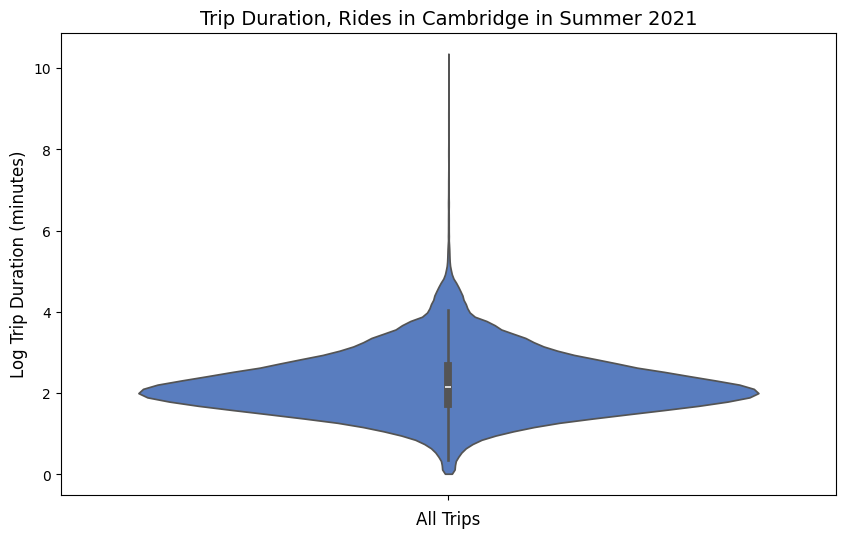

In [216]:
plt.figure(figsize=(10, 6))
sns.violinplot(y='log_travel_time_min', data=bike_rides, palette='muted', cut=0)
#plt.ylim(0, 60)  # Focus on trip durations up to 60 minutes
plt.title('Trip Duration, Rides in Cambridge in Summer 2021', fontsize=14)
plt.xlabel('All Trips', fontsize=12)
plt.ylabel('Log Trip Duration (minutes)', fontsize=12)
plt.show()